## Find box office hits

My task is to build a model of box office revenue for movies from The Movie Database. The results of this model would feed into a decision-making algorithm that a big movie theater chain uses to select which movies to run. The output of this supervised regression is critical to optimizing ticket revenue for your employer.

Current estimations are currently done mainly by intuition and checking buzz.

[Useful reference](https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation).

## Notes on this exercise...

I'm using this primarily as an opportunity to practice building transformers and Pipelines with Scikit-Learn. My complete an ML workflow and have a working model, but I'm not going to spend too much time on the model performance. 

### Check assumptions

I'm going to build a model off of these movies titles to build a box office forecast for future movies. 

* Does this need to be a regression task?
* Should it be online? Or is it okay that it's offline?
* How expansive is this data? Is it enough to make statements about other movies, or should more data be collected?
* Are these titles are representative of the full gamut of movies?
* Are movie-going patterns the same today that they were 10 years ago? Will be the same that they are 10 years later?

I'm going to treat this as a continuous regression task. It's possible to run this as a classification task or interval regression task as well.

I'm going to run it offline and in batch since the data isn't so big; if I were to deploy this project I would set it up as an online learning problem. There probably isn't enough data to make broader generalizations. And if we were to deploy, weighting movies that are more recent is a good idea as media consumption has changed significantly in just the past five years.

In [145]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter, OrderedDict
from ast import literal_eval
from itertools import chain

## 1. Get the data

This data comes from a [Kaggle competition](https://www.kaggle.com/c/tmdb-box-office-prediction/data) hosted by TMDB.

In [146]:
## renamed the training data to TMDB_movie_data.csv, and stored it in a local folder called Data
movies = pd.read_csv("../Data/TMDB_movie_data.csv")
movies.shape

(3000, 23)

There's only 3000 samples of training data, which seems a bit scarce.

In [147]:
movies.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [148]:
import pandas as pd
import numpy as np
import seaborn as sns

import datetime

In [149]:
movies[['belongs_to_collection','genres','production_companies',
        'production_countries','spoken_languages',
        'Keywords','cast','crew']].head()

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,Keywords,cast,crew
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 35, 'name': 'Comedy'}]","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,"[{'id': 107674, 'name': 'The Princess Diaries ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,NaN,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,NaN,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]","[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


These columns store data as lists of dictionaries. Time to extract info form these guys.

`popularity` is an attribute that probably wouldn't normally be available prior to release, but I'll keep it for now.

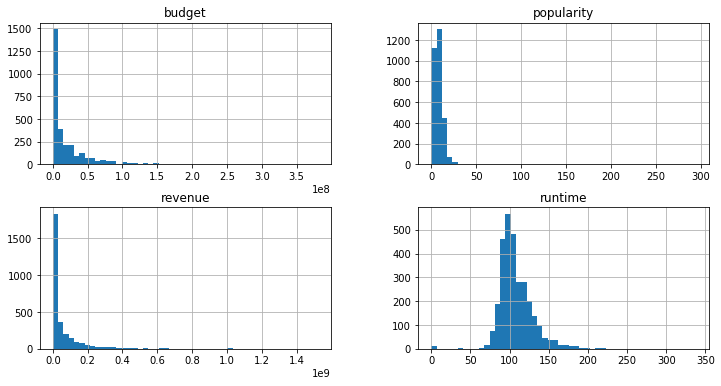

In [150]:
import matplotlib.pyplot as plt
movies[['budget','runtime','revenue','popularity']].hist(bins=50,figsize=(12,6));
plt.show();

It seems like budget generally outpaces revenue, since it's on a larger scale. Both budget and revenue are right-tailed.

Average movie length is around 100 minutes.

## 2. Split the data

Budget is one of the most important predictors of box office gross. To make sure my training and testing datasets are representative of budget distribution, I can use [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) -- sampling with respect to groupings (strata) -- to achieve this. This isn't an example of data leakage because I'm creating strata based off of outside research, rather than what I'm observing in the full dataset.

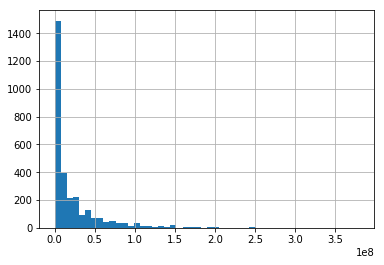

In [151]:
movies['budget'].hist(bins=50);

The buckets that I'm using are based off of the writer's guild budget agreements and a bit of tweaking on my part. I'll use low budget (< \\$30m), medium budget (between \\$30 and \\$80m), and high budget (> \\$80m)  as the strata in a temporary feature called `budget_cat`. 

In [152]:
movies['budget_cat'] = pd.cut(movies['budget'],[0,30000000,80000000,5000000000],labels=['low','medium','high'])

# make NaN cateogry, fill it in
movies['budget_cat'] = movies['budget_cat'].cat.add_categories('unknown')
movies['budget_cat'].fillna('unknown',inplace=True)

movies['budget_cat'].value_counts()

low        1505
unknown     812
medium      487
high        196
Name: budget_cat, dtype: int64

In [153]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=.2,random_state=14)

for train_index, test_index in split.split(movies, movies['budget_cat']):
    train = movies.loc[train_index]
    test = movies.loc[test_index]

print('Original data budget proportions:', movies['budget_cat'].value_counts()/len(movies),'',
      'Stratified training set budget proportions:',train['budget_cat'].value_counts()/len(train),
      sep = '\n'
     )

Original data budget proportions:
low        0.501667
unknown    0.270667
medium     0.162333
high       0.065333
Name: budget_cat, dtype: float64

Stratified training set budget proportions:
low        0.501667
unknown    0.270417
medium     0.162500
high       0.065417
Name: budget_cat, dtype: float64


Stratification successful. Next, I remove the temporary `budget_cat` attribute.

In [154]:
for dataset in [train,test]:
    dataset.drop(['budget_cat'],axis=1,inplace=True)

## Brief data exploration

Look for data structure, null values, distributions, outliers, and complexity of categorical variables.

Note: only visualize on the training data.

In [155]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

#### What's the structure of the data?

Get a sense of the amount of cleaning necessary.

In [156]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2545,2546,NaN,45000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,14.547939,...,12/12/16,133.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de...",50548152
2415,2416,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,10.597116,...,4/16/93,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de...",23202734
1919,1920,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",4.010441,...,1/23/06,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de...",2043704
1462,1463,NaN,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,8.172013,...,7/6/10,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de...",6491240
220,221,NaN,12000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",7.216103,...,4/22/09,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de...",10652498


`genres`, `spoken languages`, `keywords`, `cast`, and `crew` are stored as lists of dictionaries. That will be thorny to parse, but there's good information in there.

It looks like there will be some NLP for title and overview.

Popularity seems like slight cheating since it's probably post-release, but I'll keep it lol.

#### How many missing values?

In [157]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    1939
homepage                 1637
tagline                   478
Keywords                  228
production_companies      129
production_countries       46
spoken_languages           18
crew                       10
cast                        9
overview                    8
genres                      4
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

A lot of of missing values for `belongs_to_collection` and `homepage`. Hopefully they'll still be useful. For the most part, information looks pretty good.

In [158]:
train['original_language'].value_counts()

en    2067
fr      58
hi      37
ru      36
es      36
ja      30
it      18
cn      16
ko      15
de      14
zh      13
ta      12
sv       8
fa       5
nl       4
ro       4
da       3
pt       3
hu       2
te       2
ml       2
fi       2
tr       2
pl       2
ur       1
he       1
vi       1
ar       1
mr       1
no       1
nb       1
cs       1
id       1
Name: original_language, dtype: int64

Most of these movies are in English, followed by French, Hindi, and other languages. There's too many levels here, so I'll want bin many of these language categories as "other".

#### Correlations

In [159]:
corr_matrix = train.drop('id',axis=1).corr()
corr_matrix['revenue'].sort_values(ascending=False)

revenue       1.000000
budget        0.743399
popularity    0.469439
runtime       0.195318
Name: revenue, dtype: float64

Budget and runtime are both very strongly correlated with revenue. 

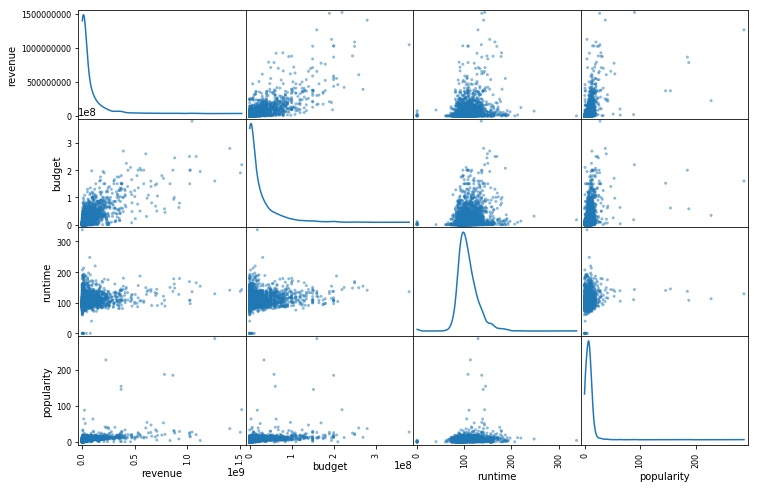

In [160]:
from pandas.plotting import scatter_matrix

attributes = ['revenue','budget','runtime','popularity']
scatter_matrix(train[attributes],diagonal='kde',figsize=(12,8));

#### Runtime: some movies have a runtime of 0

In [161]:
train.loc[train['runtime']==0,['title','runtime']]

,title,runtime
2865,Tutto tutto niente niente,0.0
2498,Hooked on the Game 2. The Next Level,0.0
1874,Missing,0.0
591,А поутру они проснулись,0.0
2645,My Old Classmate,0.0
2785,Revelation,0.0
1255,"Cry, Onion!",0.0
1541,All at Once,0.0
390,The Worst Christmas of My Life,0.0
2150,Mechenosets,0.0


For some reason or another, this data is just missing. For example, *Tutto tutto niente niente* is 96 min and *Cry, Onion* is 92 min. These can be fixed with a few quick Google searches.

In [162]:
train.loc[train['runtime']==0,'runtime'] = [96,108,122,90,98,111,92,112,86,108,93]

#### Revenue: check movies that have extremely low or no revenue

In [163]:
movies.loc[movies['revenue'] < 100, ['title','revenue']].head()

,title,revenue
150,Windwalker,18
269,Glass: A Portrait of Philip in Twelve Parts,20
280,Bats,10
312,The Cookout,12
334,Saamy,3


*Windwalker* grossed \$18m; *Glass* grossed \$20,018; *Bats* grossed \$10m, *The Cookout* grossed \$12m. There are 39 movies in this database with revenues under 100. I'm willing to bet most of them have incorrect recorded revenues. In fact, I'd be willing to bet that even most movies under \$1000 in revenue probably have incorrect labels. What I can do is test different datasets. 

I'll use a pipeline to test datasets where I ignore rows under \$100, \$500, and \$1000 in revenue, and decide which preparation method to use through cross-validation.

#### Popularity and revenue

There's several very popular movies that seem to not generate that much revenue. Would be helpful to explore these.

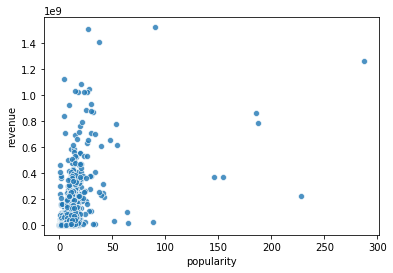

In [164]:
sns.scatterplot('popularity','revenue', data = train, alpha = .8);

In [165]:
train['revenue_to_budget'] = train['revenue']/(train['budget']+1)

train[['original_title',
       'popularity',
       'revenue_to_budget',
       'revenue',
       'budget']].sort_values('popularity',ascending=False).head(15)

train.drop('revenue_to_budget',axis=1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2545,2546,NaN,45000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,14.547939,...,12/12/16,133.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de...",50548152
2415,2416,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,10.597116,...,4/16/93,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de...",23202734
1919,1920,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",4.010441,...,1/23/06,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de...",2043704
1462,1463,NaN,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,8.172013,...,7/6/10,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de...",6491240
220,221,NaN,12000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",7.216103,...,4/22/09,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de...",10652498
378,379,NaN,35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",NaN,tt0361089,en,Valiant,The animated comedy tells the story of a lowly...,11.836827,...,3/25/05,76.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Some pigeons eat crumbs, others make history.",Valiant,"[{'id': 10336, 'name': 'animation'}, {'id': 18...","[{'cast_id': 2, 'character': 'Valiant (voice)'...","[{'credit_id': '52fe45d49251416c75063f11', 'de...",19478106
750,751,NaN,30000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0332047,en,Fever Pitch,When relaxed and charming Ben Wrightman meets ...,6.734065,...,4/6/05,103.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Comedy About The Game of Love.,Fever Pitch,"[{'id': 1480, 'name': 'baseball'}, {'id': 3419...","[{'cast_id': 1, 'character': 'Lindsey Meeks', ...","[{'credit_id': '52fe443f9251416c7502df99', 'de...",50451307
2956,2957,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0091055,en,Firewalker,A pair of adventurers try to track down an anc...,3.150899,...,11/21/86,104.0,"[{'iso_639_1': 'hu', 'name': 'Magyar'}, {'iso_...",Released,A pair of down-and-out fortune hunters cash in...,Firewalker,"[{'id': 352, 'name': 'secret passage'}, {'id':...","[{'cast_id': 1, 'character': 'Max Donigan', 'c...","[{'credit_id': '52fe45199251416c7504bbf7', 'de...",11949484
663,664,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://w

Interestingly, Baby Driver did really well for its budget, making several multiples of its originally money. It seems as though popularity alone doesn't always serve as a great barometer for revenue. For example, The Circle, Fight Club, and The Shawshank Redemption didn't do super well. But maybe online popularity could act as a lever, affecting the multiple at which a movie earns back its budget.

I should probably figure out how popularity is determined. Next question: why do moderately popular movies end up making a lot of money?

In [166]:
train.loc[train['popularity']<100,
          ['original_title',
           'popularity',
           'revenue_to_budget',
           'revenue',
           'budget']].sort_values('revenue',ascending=False).head(10)

,original_title,popularity,revenue_to_budget,revenue,budget
1126,The Avengers,89.887648,6.907081,1519557910,220000000
1761,Furious 7,27.275687,7.927628,1506249360,190000000
2770,Avengers: Age of Ultron,37.379420,5.019299,1405403694,280000000
2322,Transformers: Dark of the Moon,4.503505,5.762805,1123746996,195000000
906,The Dark Knight Rises,20.582580,4.339756,1084939099,250000000
2135,Pirates of the Caribbean: On Stranger Tides,27.887720,2.751878,1045713802,380000000
2562,Finding Dory,14.477677,5.142854,1028570889,200000000
881,Alice in Wonderland,17.285093,5.127456,1025491110,200000000
734,Zootopia,26.024868,6.825228,1023784195,150000000
2532,The Hobbit: An Unexpected Journey,23.253089,4.084414,1021103568,250000000


The movies that crushed despite pretty moderate popularity all benefited from extremely large budgets. Maybe TMDB popularity isn't all that important.

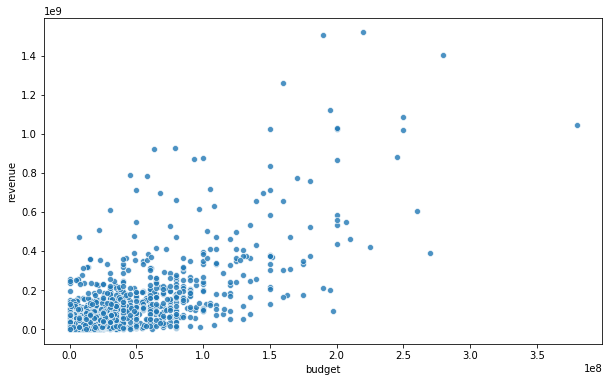

In [167]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='budget',y='revenue',data=train,alpha=.8);

In [168]:
train[['original_title','budget','revenue']].sort_values('budget',ascending=False).head(10)

,original_title,budget,revenue
2135,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
2770,Avengers: Age of Ultron,280000000,1405403694
1425,Superman Returns,270000000,391081192
1630,Transformers: The Last Knight,260000000,604942143
2532,The Hobbit: An Unexpected Journey,250000000,1021103568
906,The Dark Knight Rises,250000000,1084939099
2737,Spectre,245000000,880674609
1249,The Chronicles of Narnia: Prince Caspian,225000000,419651413
1126,The Avengers,220000000,1519557910
1880,X-Men: The Last Stand,210000000,459359555


A lot of the points are scattered towards the low end in terms of budget and revenue. There's a few movies that had really high budgets, but didn't end up generating too much revenue.

## Data cleaning and further exploration

In [169]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,revenue_to_budget
2545,2546,NaN,45000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,14.547939,...,133.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de...",50548152,1.123292e+00
2415,2416,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,10.597116,...,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de...",23202734,2.320273e+07
1919,1920,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",4.010441,...,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de...",2043704,2.043704e+06
1462,1463,NaN,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,8.172013,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de...",6491240,8.114049e-01
220,221,NaN,12000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",7.216103,...,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de...",10652498,8.877081e-01


In [170]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'revenue_to_budget'],
      dtype='object')

##  `release_date`

* http://strftime.org/
* https://kite.com/python/docs/pandas.core.indexes.accessors.DatetimeProperties

In [171]:
print("Original date format:",train['release_date'][0])
train['release_date'] = pd.to_datetime(train['release_date'],format="%m/%d/%y")
test['release_date'] = pd.to_datetime(test['release_date'],format="%m/%d/%y")
print("New date format:",train['release_date'][0])

Original date format: 2/20/15
New date format: 2015-02-20 00:00:00


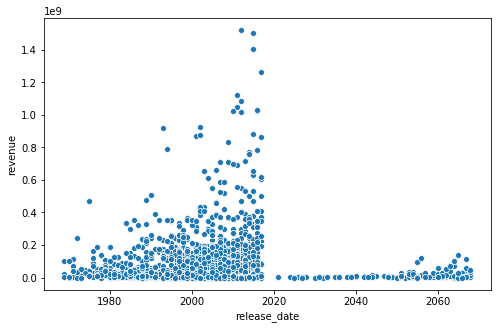

In [172]:
import seaborn as sns

plt.figure(figsize=(8,5));
sns.scatterplot(train['release_date'].dt.year,train['revenue']);

What the heck is happening here!! 

It turns out `to_datetime` converts all dates where year is 00 - 68 gets mapped to 2000 - 2068 and everything 69 - 99 gets mapped to 1969 - 1999. This is due to the datetime library's usage of POSIX/ISO C standard. ([Read more](https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year)).

All years past 2019 are actually meant to be in the 1900s. I'll fix this by subtracting 100 years from `release_date`.

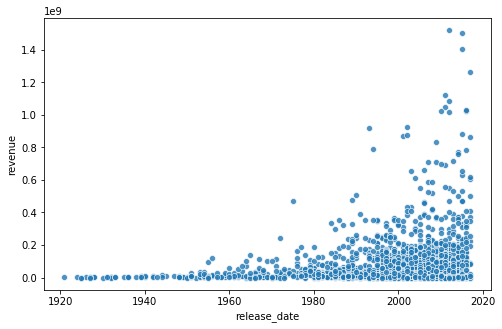

In [173]:
# subtracts years for dates that haven't yet occurred
def subtract_years(dates, n_years, last_year = 2018):
    dates_copy = dates.copy()
    dates_copy[dates_copy.dt.year > last_year] = dates_copy[dates_copy.dt.year > 2019] \
                                                - datetime.timedelta(days = n_years*365.25)
    
    return dates_copy

# subtract 100 years
train['release_date'] = subtract_years(train['release_date'],100)
test['release_date'] = subtract_years(test['release_date'],100)

plt.figure(figsize=(8,5));
sns.scatterplot(train['release_date'].dt.year,train['revenue'],alpha=.8);

Movie revenue seems to be increasing every year! Track the average each year? 

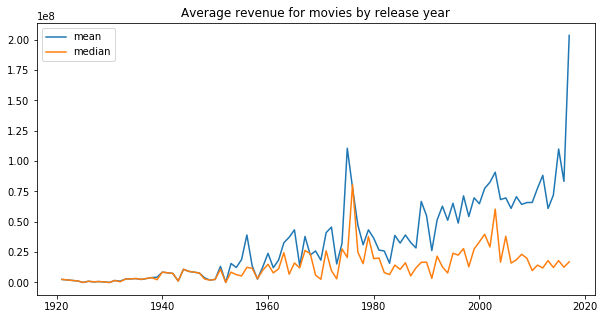

In [174]:
train['release_year'] = train['release_date'].dt.year
test['release_year'] = test['release_date'].dt.year

plt.figure(figsize=(10,5));
plt.plot(train[['release_year','revenue']].groupby('release_year').agg(['mean']));
plt.plot(train[['release_year','revenue']].groupby('release_year').agg(['median']));
plt.legend(['mean','median']);
plt.title('Average revenue for movies by release year');

While mean movie revenue increases each year (due to some probably extremely high budget films), the median revenue is relatively stable.

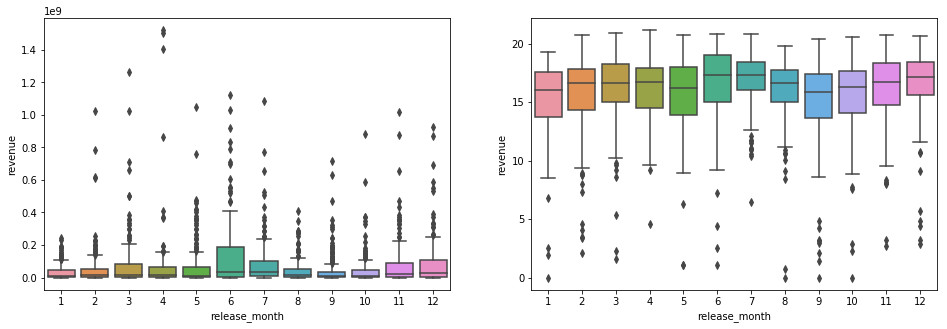

In [175]:
train['release_month'] = train['release_date'].dt.month
test['release_month'] = test['release_date'].dt.month

fig, ax = plt.subplots(1,2,figsize=(16,5),sharey=False)
sns.boxplot(train['release_month'],train['revenue'],ax=ax[0]);
sns.boxplot(train['release_month'],np.log(train['revenue']),ax=ax[1]);

June is a hot month for movies. So is December. I think I'll turn each month into a separate dummy variable. Seasons will be helpful to look at.

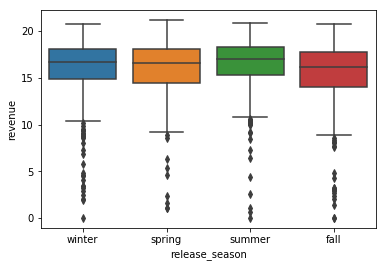

In [223]:
def get_season(dates):
    season = [1,1,2,2,2,3,3,3,4,4,4,1]
    
    season_map = {
        1:'winter',
        2:'spring',
        3:'summer',
        4:'fall'
    }
    
    return dates.dt.month.apply(lambda x: season_map[season[x - 1]])

train['release_season'] = get_season(train['release_date'])
test['release_season'] = get_season(test['release_date'])

sns.boxplot(train['release_season'],np.log(train['revenue']));

Movies appear to perform slightly better in summer than they do in the other months. Movies in fall also seem to perform worse. Based on this, I think I should make summer and fall into dummy columns (feature engineering step). I probably won't use the other seasons.

Summary of `release_date` findings: 

* Make dummies from season
* Make dummies of summer and fall

## `genres`

The `genres` field consists of a list of dictionaries, where each dictionary represents a single genre. This list is represented as a string. In order to extract the appropriate information, I'll have to convert the string to a list, then extract the genre from each element. I'll define a helper function, `get_vals()` to extract the genre from each dictionary.

In [179]:
to_fill = 'keyword'
f"this is the '{to_fill}'"

"this is the 'keyword'"

In [257]:
## takes a list of dictionaries and extracts names using the 'name' key
def get_vals(dict_list,key):
        vals = []

        for d in dict_list:
            val = d[key]
            
            if type(val) is str:
                vals.append(val.lower())
            else:
                vals.append(val)

        return vals 

def get_freq(column, key, n_top = -1, fill = 'unknown'):
    column_copy = column.copy()
    column_copy = column_copy.fillna(f"[{{'{key}':'{fill}'}}]")
    
    column_copy_all = column_copy.apply(literal_eval).apply(lambda x: get_vals(x,key))
    column_copy_flat = list(chain(*column_copy_all))
    
    counter = Counter(column_copy_flat)
    
    if n_top == -1:
        return sorted(counter.items(), key = lambda item: -item[1])
    else:
        return sorted(counter.items(), key = lambda item: -item[1])[:n_top]

get_freq(train['genres'],'name')

[('drama', 1212),
 ('comedy', 824),
 ('thriller', 631),
 ('action', 584),
 ('romance', 473),
 ('crime', 388),
 ('adventure', 352),
 ('horror', 239),
 ('science fiction', 230),
 ('family', 217),
 ('fantasy', 178),
 ('mystery', 173),
 ('animation', 120),
 ('history', 109),
 ('war', 88),
 ('music', 76),
 ('documentary', 72),
 ('western', 28),
 ('foreign', 27),
 ('unknown', 4),
 ('tv movie', 1)]

About half of the 2400 movies in the training set are drama. The 12th biggest genre, mystery, encompasses only about 7.2% of movies. I want to be careful not to generalize to other movies without sufficient data, so mystery is the smallest genre that I'll be including in my model.

How can I visualize genres?

## `production_companies`

In [258]:
get_freq(train['production_companies'],'name',30)

[('warner bros.', 160),
 ('universal pictures', 153),
 ('unknown', 129),
 ('paramount pictures', 123),
 ('twentieth century fox film corporation', 116),
 ('columbia pictures', 74),
 ('metro-goldwyn-mayer (mgm)', 66),
 ('new line cinema', 66),
 ('columbia pictures corporation', 53),
 ('walt disney pictures', 51),
 ('touchstone pictures', 51),
 ('tristar pictures', 46),
 ('relativity media', 42),
 ('canal+', 38),
 ('miramax films', 36),
 ('united artists', 32),
 ('village roadshow pictures', 28),
 ('regency enterprises', 28),
 ('lionsgate', 27),
 ('working title films', 26),
 ('dune entertainment', 24),
 ('fox searchlight pictures', 22),
 ('bbc films', 21),
 ('orion pictures', 20),
 ('studiocanal', 20),
 ('dimension films', 19),
 ('epsilon motion pictures', 19),
 ('morgan creek productions', 19),
 ('fox 2000 pictures', 18),
 ('dreamworks skg', 18)]

I'll keep the top 20 studios.

## `production_countries`

In [259]:
get_freq(movies['production_countries'],'name',20)

[('united states of america', 2282),
 ('united kingdom', 380),
 ('france', 222),
 ('germany', 167),
 ('canada', 120),
 ('india', 81),
 ('italy', 64),
 ('japan', 61),
 ('australia', 61),
 ('russia', 58),
 ('unknown', 55),
 ('spain', 54),
 ('china', 42),
 ('hong kong', 42),
 ('ireland', 23),
 ('belgium', 23),
 ('south korea', 22),
 ('mexico', 19),
 ('sweden', 18),
 ('new zealand', 17)]

## `Keywords`

In [260]:
get_freq(train['Keywords'],'name')

[('unknown', 228),
 ('woman director', 143),
 ('independent film', 128),
 ('duringcreditsstinger', 102),
 ('murder', 96),
 ('based on novel', 89),
 ('violence', 72),
 ('sport', 66),
 ('aftercreditsstinger', 61),
 ('sex', 60),
 ('biography', 60),
 ('revenge', 59),
 ('dystopia', 58),
 ('love', 56),
 ('police', 56),
 ('sequel', 55),
 ('suspense', 54),
 ('friendship', 53),
 ('teenager', 48),
 ('nudity', 48),
 ('drug', 45),
 ('female nudity', 42),
 ('prison', 40),
 ('los angeles', 39),
 ('high school', 38),
 ('musical', 38),
 ('father son relationship', 37),
 ('new york', 37),
 ('london england', 33),
 ('kidnapping', 31),
 ('detective', 31),
 ('investigation', 31),
 ('escape', 30),
 ('brother brother relationship', 30),
 ('wedding', 30),
 ('based on true story', 30),
 ('3d', 29),
 ('rape', 29),
 ('corruption', 29),
 ('paris', 29),
 ('alien', 29),
 ('family', 28),
 ('based on comic', 27),
 ('jealousy', 27),
 ('vampire', 27),
 ('soldier', 26),
 ('prostitute', 26),
 ('death', 26),
 ('robbery',

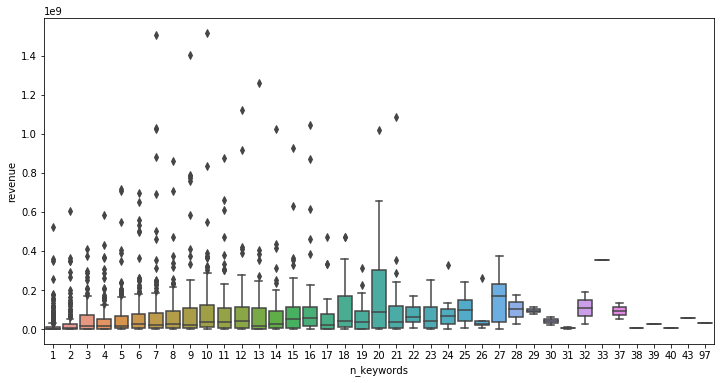

In [272]:
def count_items(column, key, fill = 'unknown'):
    column_copy = column.copy()
    column_copy = column_copy.fillna(f"[{{'{key}':'{fill}'}}]")
    
    column_copy_all = column_copy.apply(literal_eval).apply(lambda x: get_vals(x,key))
    return column_copy_all.apply(len)
    
train['n_keywords'] = count_items(train['Keywords'],'name')
test['n_keywords'] = count_items(test['Keywords'],'name')

plt.figure(figsize=(12,6));
sns.boxplot('n_keywords','revenue',data=train);

Movies with 20, 25, and 27 keywords seem to do especially well. Maybe I'll make a dummy variable out of those. 

## `cast`

* cast size
* key actors
* genders

In [265]:
train['cast_size'] = count_items(train['cast'],'name')
test['cast_size'] = count_items(test['cast'],'name')

In [261]:
get_freq(train['cast'],'name')

[('j.k. simmons', 25),
 ('robert de niro', 23),
 ('susan sarandon', 22),
 ('morgan freeman', 21),
 ('john turturro', 21),
 ('forest whitaker', 20),
 ('jason statham', 20),
 ('bill murray', 20),
 ('liam neeson', 20),
 ('samuel l. jackson', 20),
 ('dennis quaid', 19),
 ('richard jenkins', 19),
 ('alec baldwin', 19),
 ('bruce willis', 19),
 ('john goodman', 18),
 ('willem dafoe', 18),
 ('nicolas cage', 18),
 ('gene hackman', 18),
 ('sigourney weaver', 18),
 ('william h. macy', 17),
 ('bruce mcgill', 17),
 ('keith david', 17),
 ('owen wilson', 17),
 ('george clooney', 17),
 ('brian cox', 16),
 ('sylvester stallone', 16),
 ('cheech marin', 16),
 ('matt damon', 16),
 ('steve buscemi', 16),
 ('denzel washington', 16),
 ('jason bateman', 16),
 ('ethan hawke', 16),
 ('mark wahlberg', 15),
 ('kevin bacon', 15),
 ('jim broadbent', 15),
 ('john c. reilly', 15),
 ('michael shannon', 15),
 ('julia roberts', 15),
 ('mel gibson', 15),
 ('john cusack', 15),
 ('michael caine', 15),
 ('robert downey jr.'

In [263]:
get_freq(train['cast'],'gender',fill=0)

[(2, 22292), (0, 16405), (1, 10844), ('0', 9)]

0 is unknown, 1 is women, 2 is men. Kind of sucks that so much is unknown. Missed opportunity there. Could probably clean that up using a cast list.

#### Extract crew

* Departments
* Jobs
* Top names

In [502]:
crew = movies['crew']
crew.isnull().sum()

10

In [503]:
literal_eval(crew[2545])

[{'credit_id': '587cad3bc3a3684a9e01776f',
  'department': 'Lighting',
  'gender': 0,
  'id': 1739785,
  'job': 'Rigging Grip',
  'name': 'Shawn S. Ryder',
  'profile_path': None},
 {'credit_id': '587cad4b9251413e9201876d',
  'department': 'Lighting',
  'gender': 0,
  'id': 1739786,
  'job': 'Rigging Grip',
  'name': 'Chris Ryerson',
  'profile_path': None},
 {'credit_id': '56ec832092514143fc0037bc',
  'department': 'Directing',
  'gender': 2,
  'id': 36602,
  'job': 'Director',
  'name': 'Peter Berg',
  'profile_path': '/1pR16H0zqRG49ns8cYykYpodgGF.jpg'},
 {'credit_id': '57f383b09251410c28009254',
  'department': 'Production',
  'gender': 1,
  'id': 67682,
  'job': 'Producer',
  'name': 'Dorothy Aufiero',
  'profile_path': None},
 {'credit_id': '57f383c19251410c2a0090ab',
  'department': 'Production',
  'gender': 0,
  'id': 935717,
  'job': 'Producer',
  'name': 'Dylan Clark',
  'profile_path': None},
 {'credit_id': '582a1f569251417b2303a7b2',
  'department': 'Production',
  'gender':

In [504]:
crew = crew.fillna("[{'department':'unknown','name':'unknown','job':'unknown'}]")

In [505]:
crew.isnull().sum()

0

In [506]:
crew_departments = crew.apply(literal_eval).apply(lambda x: get_vals(x,'department'))
crew_departments_all = list(chain(*crew_departments))
crew_departments_count = Counter(crew_departments_all)

In [507]:
sorted(crew_departments_count.items(), key = lambda item: -item[1])

[('production', 12608),
 ('sound', 7539),
 ('art', 6480),
 ('crew', 5921),
 ('writing', 5310),
 ('costume & make-up', 4911),
 ('camera', 4366),
 ('directing', 4033),
 ('editing', 3603),
 ('visual effects', 2795),
 ('lighting', 1054),
 ('unknown', 10),
 ('actors', 2)]

Crew jobs.

In [508]:
crew_jobs = crew.apply(literal_eval).apply(lambda x: get_vals(x,'job'))
crew_jobs_all = list(chain(*crew_jobs))
crew_jobs_count = Counter(crew_jobs_all)

In [509]:
sorted(crew_jobs_count.items(), key = lambda item: -item[1])

[('producer', 4794),
 ('executive producer', 2695),
 ('director', 2604),
 ('screenplay', 2409),
 ('editor', 2277),
 ('casting', 1971),
 ('director of photography', 1818),
 ('original music composer', 1571),
 ('art direction', 1472),
 ('production design', 1325),
 ('costume design', 1264),
 ('writer', 1244),
 ('set decoration', 1083),
 ('makeup artist', 873),
 ('sound re-recording mixer', 789),
 ('camera operator', 756),
 ('script supervisor', 746),
 ('hairstylist', 628),
 ('sound effects editor', 614),
 ('visual effects supervisor', 588),
 ('still photographer', 580),
 ('music editor', 573),
 ('stunts', 558),
 ('animation', 545),
 ('dialogue editor', 529),
 ('visual effects producer', 520),
 ('music', 514),
 ('stunt coordinator', 509),
 ('supervising sound editor', 490),
 ('co-producer', 481),
 ('associate producer', 478),
 ('foley', 452),
 ('costume supervisor', 449),
 ('story', 423),
 ('set costumer', 415),
 ('sound designer', 415),
 ('gaffer', 379),
 ('novel', 374),
 ('set designer'

Crew names.

In [510]:
crew_names = crew.apply(literal_eval).apply(lambda x: get_vals(x,'name'))
crew_names_all = list(chain(*crew_names))
crew_names_count = Counter(crew_names_all)

sorted(crew_names_count.items(), key = lambda items: -items[1])

[('avy kaufman', 41),
 ('robert rodriguez', 35),
 ('deborah aquila', 33),
 ('jerry goldsmith', 30),
 ('luc besson', 30),
 ('james newton howard', 29),
 ('tricia wood', 29),
 ('francine maisler', 29),
 ('steven spielberg', 28),
 ('janet hirshenson', 26),
 ('kerry barden', 26),
 ('james horner', 26),
 ('mary vernieu', 26),
 ('bob weinstein', 25),
 ('jane jenkins', 25),
 ('john debney', 25),
 ('harvey weinstein', 24),
 ('clint eastwood', 24),
 ('sarah finn', 24),
 ('billy hopkins', 24),
 ('hans bjerno', 23),
 ('mark isham', 23),
 ('scott rudin', 23),
 ('alan silvestri', 22),
 ('tim bevan', 22),
 ('eric fellner', 22),
 ('arnon milchan', 22),
 ('danny elfman', 22),
 ('francis ford coppola', 21),
 ('randi hiller', 21),
 ('john papsidera', 21),
 ('bruce berman', 21),
 ('neal h. moritz', 21),
 ('thomas newman', 20),
 ('suzanne smith', 20),
 ('graeme revell', 20),
 ('mindy marin', 20),
 ('michael mann', 19),
 ('frank marshall', 19),
 ('robert zemeckis', 18),
 ('randall poster', 18),
 ('marco be

## Data pre-processing pipelines for machine learning

Using pipelines and custom transformers.

In [472]:
## training data and labels
movies = strat_train.drop('revenue',axis=1)
movies_revenue = strat_train['revenue'].copy()

It looks like we're missing a lot of information in `belongs_to_collection` and `homepage`, I'll have to explore those two variables individually and decide whether or not to keep them.

In [473]:
movies.isnull().sum().sort_values(ascending=False)/len(movies)

belongs_to_collection    0.807917
homepage                 0.682083
tagline                  0.199167
Keywords                 0.095000
production_companies     0.053750
production_countries     0.019167
spoken_languages         0.007500
crew                     0.004167
cast                     0.003750
overview                 0.003333
genres                   0.001667
runtime                  0.000833
poster_path              0.000417
popularity               0.000000
original_title           0.000000
original_language        0.000000
imdb_id                  0.000000
release_date             0.000000
status                   0.000000
budget                   0.000000
title                    0.000000
id                       0.000000
dtype: float64

### Numeric pipeline

There are two independent numeric variables, `budget` and `runtime`. In the trianing set, `runtime` is the only field missing runtime information. I'm going to impute both of these in a pipeline in case there are missing observations in the test dataset.

In [474]:
import numpy as np

## can use this to find all numeric features
movies_num = movies.drop('id',axis=1).select_dtypes(include='number')
movies_num.head()

,budget,popularity,runtime
2545,45000000,14.547939,133.0
2415,0,10.597116,98.0
1919,0,4.010441,96.0
1462,8000000,8.172013,101.0
220,12000000,7.216103,132.0


In [475]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    PowerTransformer(method='yeo-johnson',standardize=False),
    StandardScaler()
)

Because I'm planning on running a linear regression, I need to make sure that my features are on the same scale so that a) gradient descent converges quickly and b) I get better interpretability of my regression coefficients. This logic doesn't apply with random forests though, since they're based on decision thresholds.

In [476]:
pd.DataFrame(num_pipeline.fit_transform(movies_num),columns=movies_num.columns).head()

,budget,popularity,runtime
0,0.920848,1.056325,1.128977
1,-1.501316,0.623430,-0.431555
2,-1.501316,-0.527353,-0.522331
3,0.383308,0.288847,-0.295753
4,0.499011,0.135402,1.085046


### Categorical pipeline

In [477]:
movies.select_dtypes(include='object').head()

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,Keywords,cast,crew
2545,NaN,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.patriotsdayfilm.com/,tt4572514,en,Patriots Day,An account of Boston Police Commissioner Ed Da...,/mIDxsJTrOC7NhgOo3GziiHyKfsQ.jpg,"[{'name': 'CBS Films', 'id': 5490}, {'name': '...","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}, {'...",12/12/16,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,The inside story of the world's greatest manhunt.,Patriots Day,"[{'id': 1680, 'name': 'boston'}, {'id': 1700, ...","[{'cast_id': 4, 'character': 'Sgt. Tommy Saund...","[{'credit_id': '587cad3bc3a3684a9e01776f', 'de..."
2415,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0106387,en,Benny & Joon,A mentally ill young woman finds her love in a...,/2a7amuuML6xvBn6XWV1sPG1Cmd5.jpg,"[{'name': 'Roth-Arnold Productions', 'id': 156...","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/93,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A romance on the brink of reality.,Benny & Joon,"[{'id': 1155, 'name': 'brother sister relation...","[{'cast_id': 2, 'character': 'Sam', 'credit_id...","[{'credit_id': '52fe43adc3a36847f8066f63', 'de..."
1919,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0458367,en,Right at Your Door,"A dirty bomb goes off in Los Angeles, jamming ...",/6h24yrqU5TfAMI6dZBdiDUU3M0p.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",1/23/06,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Right at Your Door,"[{'id': 4458, 'name': 'post-apocalyptic'}]","[{'cast_id': 3, 'character': 'Lexi', 'credit_i...","[{'credit_id': '52fe46709251416c75078597', 'de..."
1462,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://focusfeatures.com/its_kind_of_a_funny_s...,tt0804497,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,/wADblWdHMk2SIaZRBazTGOTBf4w.jpg,"[{'name': 'Focus Features', 'id': 10146}]","[{'iso_3166_1': 'US', 'name': 'United States o...",7/6/10,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,"[{'id': 236, 'name': 'suicide'}, {'id': 894, '...","[{'cast_id': 11, 'character': 'Craig Gilner', ...","[{'credit_id': '567f355792514132db008f84', 'de..."
220,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",http://www.cityoflifeanddeath.co.uk/,tt1124052,zh,南京!南京!,"City of Life and Death takes place in 1937, du...",/zCzNvesRkmkmlK0g2Abp4y4zhb0.jpg,"[{'name': 'Media Asia Films', 'id': 5552}, {'n...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",4/22/09,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,City of Life and Death,"[{'id': 1327, 'name': 'war crimes'}, {'id': 15...","[{'cast_id': 1, 'character': 'Lu Jianxiong', '...","[{'credit_id': '53afe79a0e0a265975005fda', 'de..."


Check missing values: these are all the values that I need to fill as unknown. 

In [478]:
movies.select_dtypes(include='object').isnull().sum().sort_values(ascending=False)

belongs_to_collection    1939
homepage                 1637
tagline                   478
Keywords                  228
production_companies      129
production_countries       46
spoken_languages           18
crew                       10
cast                        9
overview                    8
genres                      4
poster_path                 1
status                      0
release_date                0
original_title              0
original_language           0
imdb_id                     0
title                       0
dtype: int64

The ones wrapped in dictionaries are `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `Keywords`, `cast`, and `crew`.

#### Build the categorical transformer

In [511]:
## TransformerMixin gives fit_transform()
## BaseEstimator gives get_params() and set_params(), useful for hyperparameter tuning
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X,y=None):
        return X.loc[:,self.key]

class CatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.genres = []
        self.top_genres = []
        
        self.studios = []
        self.top_studios = []
        
        self.countries = []
        self.top_countries = []
        
        self.keywords = []
        self.top_keywords = []
        
        self.cast_members = []
        self.top_cast_members = []
        
        self.cast_genders = []
        
        self.crew_departments = []
        self.top_crew_departments = []
        
        self.crew_jobs = []
        self.top_crew_jobs = []
        
        self.crew_names = []
        self.top_crew_names = []
        
    ## extracts names from a list of dictionary objects
    def _get_names(self,column):
        column = column.fillna("[{'name':'unknown'}]")    ## fill missing values 
        column = column.apply(literal_eval).apply(lambda x: get_vals(x,'name')) ## extract genre names 
        return column
    
    def _get_genders(self,column):
        column = column.fillna("[{'gender':0}]")
        column = column.apply(literal_eval).apply(lambda x: get_vals(x,'gender'))
        return column
    
    def _get_departments(self,column):
        column = column.fillna("[{'department':'unknown'}]")
        column = column.apply(literal_eval).apply(lambda x: get_vals(x,'department'))
        return column
    
    def _get_jobs(self,column):
        column = column.fillna("[{'job':'unknown'}]")
        column = column.apply(literal_eval).apply(lambda x: get_vals(x,'job'))
        return column

    ## extract top names from a column of name lists 
    def _get_top_names(self,column,top_n=10):
        elements = list(chain(*column))                                     ## unpack a list of lists
        top_elements = [t[0] for t in Counter(elements).most_common(top_n)] ## extract top names from Collections obj      
        return top_elements        
    
    def fit(self,X,y=None):
        ## genres
        self.genres = self._get_names(X['genres'])
        self.top_genres = self._get_top_names(self.genres,12)   
        if 'unknown' in self.top_genres:
            self.top_genres.remove('unknown')
        
        ## studios
        self.studios = self._get_names(X['production_companies'])
        self.top_studios = self._get_top_names(self.studios,20)
        if 'unknown' in self.top_studios:
            self.top_studios.remove('unknown')
        
        ## countries
        self.countries = self._get_names(X['production_countries'])
        self.top_countries = self._get_top_names(self.countries,15)
        if 'unknown' in self.top_countries:
            self.top_countries.remove('unknown')
        
        ## keywords
        self.keywords = self._get_names(X['Keywords'])
        self.top_keywords = self._get_top_names(self.keywords,20)
        if 'unknown ' in self.top_keywords:
            self.top_keywords.remove('unknown')
            
        ## cast
        self.cast_members = self._get_names(X['cast'])
        self.top_cast_members = self._get_top_names(self.cast_members,50)
        if 'unknown' in self.top_cast_members:
            self.top_cast_members.remove('unknown')
        
        self.cast_genders = self._get_genders(X['cast'])
        
        ## crew
        self.crew_departments = self._get_departments(X['crew'])
        self.top_crew_departments = self._get_top_names(self.crew_departments,11)
        if 'unknown' in self.top_crew_departments:
            self.top_crew_departments.remove('unknown')
        
        self.crew_jobs = self._get_jobs(X['crew'])
        self.top_crew_jobs = self._get_top_names(self.crew_jobs,75)
        if 'unknown' in self.top_crew_jobs:
            self.top_crew_jobs.remove('unknown')

        self.crew_names = self._get_names(X['crew'])
        self.top_crew_names = self._get_top_names(self.crew_names,50)
        if 'unknown' in self.top_crew_names:
            self.top_crew_names.remove('unknown')
        
        return self
    
    def transform(self,X,y=None):    
        ## engineer features from date
        dates = pd.to_datetime(X['release_date'],format="%m/%d/%y")
        X['release_month'] = dates.dt.month
        X['release_day'] = dates.dt.day
        X['release_year'] = dates.dt.year
        X['release_dow'] = dates.dt.weekday
        
        months = dates.dt.month
        ## 1 = winter; 2 = spring; 3 = summer; 4 = fall
        season_map = [1,1,2,2,2,3,3,3,4,4,4,1]
        season = months.apply(lambda x: season_map[x-1])
        X['is_summer'] = season.apply(lambda x: 1 if x == 3 else 0) 
        X['is_winter'] = season.apply(lambda x: 1 if x == 1 else 0) 

        X = X.drop(['release_date'],axis=1)
        
        ## top genre columns
        for top_genre in self.top_genres:
            X['genre_'+top_genre] = self.genres.apply(lambda movie_genres: 1 if top_genre in movie_genres else 0)
        X = X.drop('genres', axis=1) ## get rid of column so that the model can process 
        
        ## production studio columns
        for top_studio in self.top_studios:
            X['studio_'+top_studio] = self.studios.apply(lambda movie_studios: 1 if top_studio in movie_studios else 0)
        X = X.drop('production_companies',axis=1)
        
        ## production country columns
        for top_country in self.top_countries:
            X['country_'+top_country] = self.countries.apply(lambda movie_countries: 1 if top_country in movie_countries else 0)
        X = X.drop('production_countries',axis=1)
        
        ## get languages
        languages_dummy = pd.get_dummies(movies['original_language'],prefix='lang')
        X = pd.concat([X, languages_dummy], axis=1, join='outer')
        X = X.drop('original_language',axis=1)
        
        ## extract keyword info: number of keywords, top keywords
        X['num_keywords'] = self.keywords.apply(len)
        
        for top_keyword in self.top_keywords:
            X['keyword_'+top_keyword] = self.keywords.apply(lambda movie_keywords: 1 if top_keyword in movie_keywords else 0)
        X = X.drop('Keywords',axis=1) 
        
        ## extract cast info: number of cast, number of each gender, top keywords
        X['num_cast'] = self.cast_members.apply(len)
        
        for top_cast_member in self.top_cast_members:
            X['cast_'+top_cast_member] = self.cast_members.apply(lambda movie_cast_members: \
                                                                  1 if top_cast_member in movie_cast_members else 0)
        X['num_actresses'] = self.cast_genders.apply(lambda x: x.count(1))
        X['num_actors'] = self.cast_genders.apply(lambda x: x.count(2))
        
        X = X.drop('cast',axis=1)
        
        ## extract crew info: number of departments, number of jobs, and top names
        for top_department in self.top_crew_departments:
            X['crew_department_'+top_department] = self.crew_departments.apply(lambda x: x.count(top_department))
            
        for top_job in self.top_crew_jobs:
            X['crew_job_'+top_job] = self.crew_jobs.apply(lambda x: x.count(top_job))

        for top_name in self.top_crew_names:
            X['crew_name_'+top_name] = self.crew_names.apply(lambda x: x.count(top_name))
            
        X = X.drop('crew',axis=1)
        
        ## homepage
        X['has_homepage'] = 0
        X.loc[X['homepage'].isnull() == False,'has_homepage'] = 1
        X = X.drop('homepage',axis=1) 
        
        return X
    

#### Build the categorical pipeline

In [512]:
from sklearn.pipeline import Pipeline

cat_pipeline = Pipeline([
    ('cat_selector',FeatureSelector(['release_date',
                                     'genres',
                                     'production_companies',
                                     'production_countries',
                                     'original_language',
                                     'Keywords',
                                     'cast',
                                     'crew',
                                     'homepage'
                                    ])),
    ('cat_transformer',CatTransformer())
])

#### Test pipeline

In [513]:
cat_pipeline.fit_transform(movies);

### Put the pipelines together 

In [514]:
from sklearn.pipeline import FeatureUnion

## these give you the columns you want
num_cols = list(movies.drop('id',axis=1).select_dtypes(include='number').columns)
cat_cols = list(movies.select_dtypes('object').columns)

In [515]:
num_pipeline = make_pipeline(
    FeatureSelector(num_cols),
    SimpleImputer(strategy='median'),
    PowerTransformer(method='yeo-johnson',standardize=False),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    FeatureSelector(['release_date',
                     'genres',
                     'production_companies',
                     'production_countries',
                     'original_language',
                     'Keywords',
                     'cast',
                     'crew',
                     'homepage'
                    ]), ## use cat_cols in the future
    CatTransformer()
)

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

Transform the data

In [516]:
num_features = num_cols.copy()
cat_features = list(cat_pipeline.fit_transform(movies).columns)

## these are all the column names
attributes = num_features + cat_features 

movies_prepared = full_pipeline.fit_transform(movies)

In [517]:
## Total number of features
len(num_features) + len(cat_features)

298

In [518]:
movies_prepared.shape

(2400, 298)

# Another round of exploration

Now that the data has been processed, this is another opportunity to visualize data.

In [519]:
movies_prepared = pd.DataFrame(movies_prepared,columns=attributes)

In [520]:
list(movies_prepared.columns)

['budget',
 'popularity',
 'runtime',
 'release_month',
 'release_day',
 'release_year',
 'release_dow',
 'is_summer',
 'is_winter',
 'genre_drama',
 'genre_comedy',
 'genre_thriller',
 'genre_action',
 'genre_romance',
 'genre_crime',
 'genre_adventure',
 'genre_horror',
 'genre_science fiction',
 'genre_family',
 'genre_fantasy',
 'genre_mystery',
 'studio_warner bros.',
 'studio_universal pictures',
 'studio_paramount pictures',
 'studio_twentieth century fox film corporation',
 'studio_columbia pictures',
 'studio_metro-goldwyn-mayer (mgm)',
 'studio_new line cinema',
 'studio_columbia pictures corporation',
 'studio_walt disney pictures',
 'studio_touchstone pictures',
 'studio_tristar pictures',
 'studio_relativity media',
 'studio_canal+',
 'studio_miramax films',
 'studio_united artists',
 'studio_village roadshow pictures',
 'studio_regency enterprises',
 'studio_lionsgate',
 'studio_working title films',
 'country_united states of america',
 'country_united kingdom',
 'countr

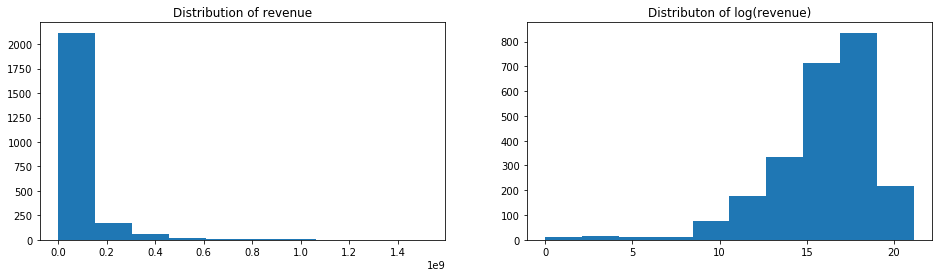

In [521]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize = (16, 4))

## split figure into 1 row and 2 columns, plot 1st plot
plt.subplot(1,2,1)
plt.hist(movies_revenue);
plt.title("Distribution of revenue");

## split figure into 1 row and 2 columns, plot 2nd plot
plt.subplot(1,2,2)
plt.hist(np.log(movies_revenue));
plt.title("Distributon of log(revenue)");

There's high skew, so it might be better for me to use log of movies revenue.

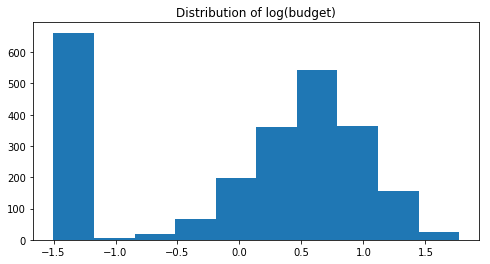

In [522]:
plt.figure(figsize = (8,4))
plt.hist(movies_prepared['budget'])
plt.title("Distribution of log(budget)");

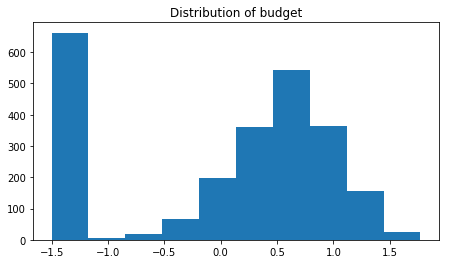

In [523]:
fig, ax = plt.subplots(figsize = (16, 4))

plt.subplot(1,2,1)
plt.hist(movies_prepared['budget']);
plt.title('Distribution of budget');

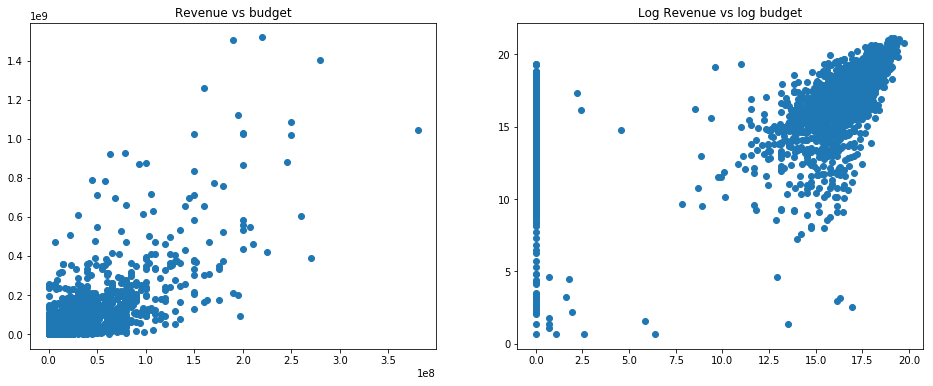

In [524]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(movies['budget'], movies_revenue)
plt.title('Revenue vs budget');

plt.subplot(1, 2, 2)
plt.scatter(np.log(movies['budget']+1), np.log(movies_revenue+1))
plt.title('Log Revenue vs log budget');

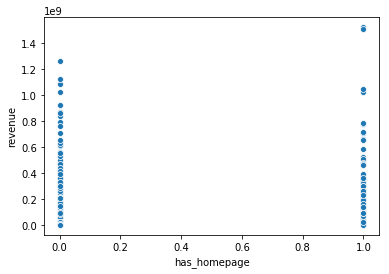

In [525]:
sns.scatterplot(movies_prepared['has_homepage'],movies_revenue);
#plt.title('Revenue for film with and without homepage');

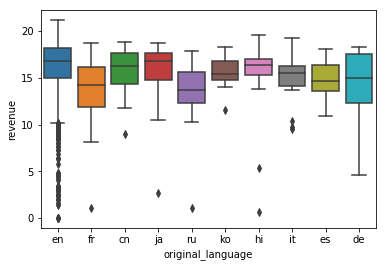

In [526]:
top_ten = movies['original_language'].isin(movies['original_language'].value_counts().head(10).index)
sns.boxplot(movies.loc[top_ten,'original_language'],np.log(movies_revenue[top_ten]));

English movies are most popular, and Chinese and Japanese movies consistently tend to do pretty well. French, Spanish, and Russian movies aren't too popular worldwide...

Movies in Denmark have received significant commercial success, but there's a lot of variability in how well they do. 

#### How does release month affect revenue?

/Users/collindching/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


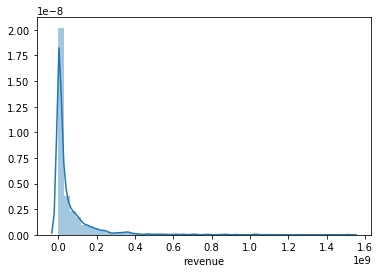

In [531]:
sns.distplot(movies_revenue);

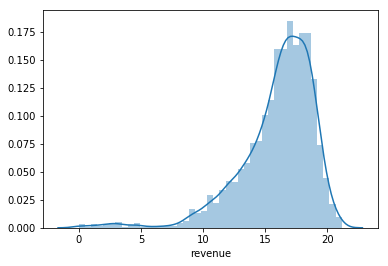

In [532]:
sns.distplot(np.log(movies_revenue))

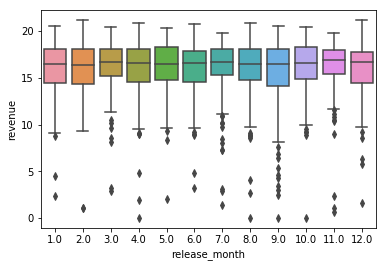

In [533]:
import seaborn as sns

sns.boxplot(movies_prepared['release_month'],np.log(movies_revenue))

Does more casting employees generally result in better box offices?

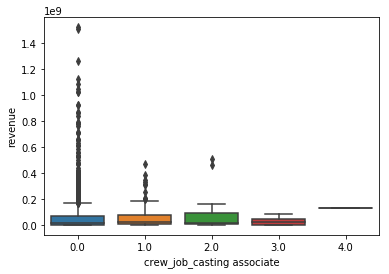

In [534]:
sns.boxplot(movies_prepared['crew_job_casting associate'],movies_revenue)

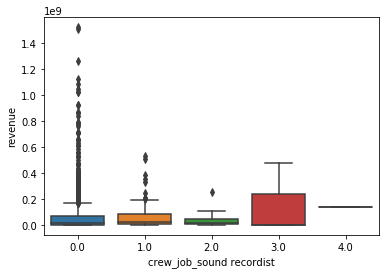

In [535]:
sns.boxplot(movies_prepared['crew_job_sound recordist'],movies_revenue)

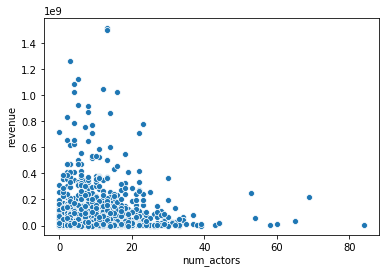

In [536]:
sns.scatterplot(movies_prepared['num_actors'],movies_revenue)

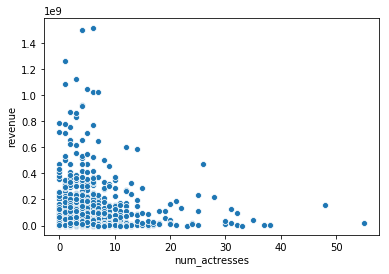

In [537]:
sns.scatterplot(movies_prepared['num_actresses'],movies_revenue)

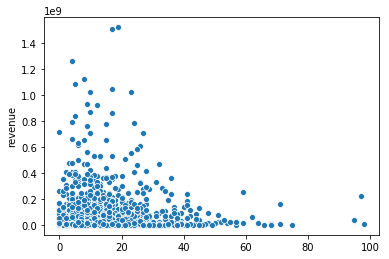

In [538]:
sns.scatterplot(movies_prepared['num_actors'] + movies_prepared['num_actresses'],movies_revenue)

Seem's like theres a sweetspot for how many actors you want to have, which is somewhere between 3 and 10. One thing I could do is make a bin for when the data is at this sweetspot. 

#### Which actor brings in the most bacon?

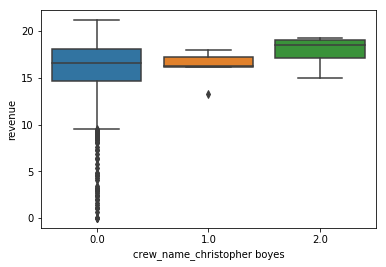

In [539]:
sns.boxplot(x=movies_prepared['crew_name_christopher boyes'],y=np.log(movies_revenue))

When he's listed twice... movies do better.

## Linear regression

In [540]:
from sklearn.linear_model import LinearRegression

## fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(movies_prepared, movies_revenue)

from sklearn.metrics import mean_squared_error

## make predictions and evalute
movies_predictions = lin_reg.predict(movies_prepared)
lin_mse = mean_squared_error(movies_revenue,movies_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

83780248.53569794

In [541]:
lin_reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Test this out on sample predictions.

As expected, the predictions weren't that close. Still, we can look at the regression coefficients below just for fun. 


In [542]:
sorted(list(zip(lin_reg.coef_, attributes)),reverse=True)

[(182878917.5168333, 'crew_name_christopher boyes'),
 (122889161.6011991, 'crew_name_howard shore'),
 (107789770.92656466, 'crew_name_janet hirshenson'),
 (97343596.57933274, 'crew_name_harvey weinstein'),
 (90790790.84352054, 'studio_walt disney pictures'),
 (90361305.7799567, 'crew_name_neal h. moritz'),
 (85053995.92745826, 'crew_name_michael bay'),
 (66742733.25766785, 'crew_name_steven spielberg'),
 (63879759.408743165, 'crew_name_james newton howard'),
 (61847932.15246678, 'crew_name_bruce berman'),
 (61322028.75221338, 'cast_johnny depp'),
 (60019502.891423464, 'cast_john turturro'),
 (58872866.74178722, 'cast_samuel l. jackson'),
 (57583240.04740778, 'country_japan'),
 (57068840.090989545, 'cast_jason bateman'),
 (56347034.584352836, 'crew_name_thomas newman'),
 (54086307.08754551, 'keyword_sequel'),
 (51074772.447435565, 'crew_name_sarah finn'),
 (50767869.05224903, 'cast_meryl streep'),
 (50299954.54241945, 'crew_name_j.j. makaro'),
 (45888791.502323754, 'studio_new line cine

It looks like adventure flicks generally do well in the box office. 

### Cross-validate

In [543]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard deviation:", scores.std())
    
lin_scores = cross_val_score(lin_reg,movies_prepared,movies_revenue,scoring="neg_mean_squared_error",cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [9.44906683e+07 4.07978277e+17 9.22440973e+07 1.06125784e+16
 7.62006950e+15 5.63684951e+17 1.87109444e+17 6.81864714e+15
 1.04842541e+08 2.59199135e+17]
Mean: 1.4430231030894422e+17
Standard deviation: 1.9451651681277206e+17


A variance of \\$11m, with \\$20m in std error is not good. We can do better with random forest.

## Random forest

Run a grid search to find the best values for the model. 

In [544]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[200,300],
    'max_depth':[6,8,10,12,14],
    'max_features': [80,120,160,200]
}

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,cv=10,
                          scoring="neg_mean_squared_error",verbose=1,n_jobs=4)
grid_search.fit(movies_prepared,movies_revenue)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:  7.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [200, 300], 'max_depth': [6, 8, 10, 12, 14], 'max_features': [80, 120, 160, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [545]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 160, 'n_estimators': 300}

In [546]:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features=160, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [547]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),params)

81236178.40991595 {'max_depth': 6, 'max_features': 80, 'n_estimators': 200}
81589879.08374847 {'max_depth': 6, 'max_features': 80, 'n_estimators': 300}
80505154.791822 {'max_depth': 6, 'max_features': 120, 'n_estimators': 200}
80119050.83966422 {'max_depth': 6, 'max_features': 120, 'n_estimators': 300}
79521212.17052032 {'max_depth': 6, 'max_features': 160, 'n_estimators': 200}
79668109.88752837 {'max_depth': 6, 'max_features': 160, 'n_estimators': 300}
79433892.88261957 {'max_depth': 6, 'max_features': 200, 'n_estimators': 200}
79202794.50227381 {'max_depth': 6, 'max_features': 200, 'n_estimators': 300}
79802688.60736932 {'max_depth': 8, 'max_features': 80, 'n_estimators': 200}
79614307.11400872 {'max_depth': 8, 'max_features': 80, 'n_estimators': 300}
78932786.04406555 {'max_depth': 8, 'max_features': 120, 'n_estimators': 200}
79074680.83766097 {'max_depth': 8, 'max_features': 120, 'n_estimators': 300}
78793028.68122487 {'max_depth': 8, 'max_features': 160, 'n_estimators': 200}
79023

In [548]:
## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
feature_importances = best_rf.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4034067027280513, 'budget'),
 (0.1872125514681377, 'popularity'),
 (0.020018471808829895, 'num_actresses'),
 (0.01925114299320772, 'crew_department_visual effects'),
 (0.01782290932948836, 'runtime'),
 (0.01679634884872284, 'crew_job_art direction'),
 (0.01571118665314089, 'num_actors'),
 (0.015221629928989905, 'num_cast'),
 (0.011332461749048976, 'crew_name_christopher boyes'),
 (0.011216827655008851, 'release_month'),
 (0.00970797460570445, 'genre_adventure'),
 (0.008941105017870921, 'release_year'),
 (0.008045800305522639, 'crew_job_camera operator'),
 (0.00803496677902616, 'num_keywords'),
 (0.006975013277581975, 'crew_department_costume & make-up'),
 (0.0067638209506967195, 'crew_name_michael bay'),
 (0.00651544860827038, 'crew_job_producer'),
 (0.0060140252114187585, 'release_day'),
 (0.00563384887395256, 'crew_department_art'),
 (0.005565921610113304, 'crew_job_animation'),
 (0.005477536026818248, 'release_dow'),
 (0.005243884426700183, 'crew_department_camera'),
 (0.0050154

## Things I would do next:

* process additional features
* text processing with NLP
* feature engineering
* add external data
* feature selection
* run more sophisticated models like XGB
* test on test data